In [50]:
import matplotlib.pyplot as plt
import time
from solvers import *

In [51]:
n = 100
m = 100
density = 0.1  # Probability of observing each entry

# seed
seed = int(time.time())

# Generate synthetic problem
X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density,
                                                                 seed - 1)  # seed-1 to avoid overlap with the gaussian initialization seed as they'd be the same otherwise

In [52]:
from sklearn.decomposition import TruncatedSVD


def compare_solvers(X_obs, X_true, u0, v0, mask, lambda_als=None, gd_params=None, plot=False):
    """
    Compare the performance of Alternating Optimization (AO), AO with normalization and Gradient Descent.

    :param X_obs: Incomplete matrix (n x n), missing entries as zeros
    :param X_true: Ground truth matrix (n x n)
    :param u0: Initial guess for vector u (n,).
    :param v0: Initial guess for vector v (n,).
    :param mask: Binary mask of observed entries (n x n), dtype=bool
    :param lambda_als: Regularization strength for AO and AON as a list
    :param gd_params: Gradient descent parameters as a list [lr, lambda_reg]
    :param plot: If True, plot residual curves
    """

    if lambda_als is None:
        lambda_als = [0.403, 1.5e-2]

    print("=== Alternating Optimization (AO) ===")
    start = time.time()
    u, v, it, res, hist = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=1500,
        lambda_reg=lambda_als[0], verbose=False, track_residuals=plot
    )
    end = time.time()
    ao_sol = np.outer(u, v)
    observed_error_ao = np.linalg.norm((ao_sol - X_true) * mask, 'fro')
    full_error_ao = np.linalg.norm(ao_sol - X_true, 'fro')
    print(
        f"AO: Residual={res:.6f}, Observed Error={observed_error_ao:.8f}, Full Error={full_error_ao:.8f}, Iter={it}, Time={end - start:.4f}s")

    print("\n=== AO with Normalization (AON) ===")
    start = time.time()
    u, v, it, res, hist2 = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=1500,
        lambda_reg=lambda_als[1], norm_v=True, verbose=False, track_residuals=plot
    )
    end = time.time()
    aon_sol = np.outer(u, v)
    observed_error_aon = np.linalg.norm((aon_sol - X_true) * mask, 'fro')
    full_error_aon = np.linalg.norm(aon_sol - X_true, 'fro')
    print(
        f"AON: Residual={res:.6f}, Observed Error={observed_error_aon:.8f}, Full Error={full_error_aon:.8f}, Iter={it}, Time={end - start:.4f}s")

    print("\n=== Gradient Descent (GD) ===")
    if gd_params is None:
        gd_params = [9.41e-04, 6.95e-05]
    lr = gd_params[0]
    lambda_gd = gd_params[1]
    start = time.time()
    u, v, it, res, hist3 = gradient_descent_rank1(
        X_obs, mask, u_init=u0.copy(), v_init=v0.copy(),
        max_it=1500, lr=lr, lambda_reg=lambda_gd,
        tol=1e-8, verbose=False, track_residuals=plot
    )
    end = time.time()
    gd_sol = np.outer(u, v)
    observed_error_gd = np.linalg.norm((gd_sol - X_true) * mask, 'fro')
    full_error_gd = np.linalg.norm(gd_sol - X_true, 'fro')
    print(
        f"GD: Residual={res:.6f}, Observed Error={observed_error_gd:.8f}, Full Error={full_error_gd:.8f}, Iter={it}, Time={end - start:.4f}s")

    # Plot residuals if available
    if plot:
        plt.figure(figsize=(10, 6))
        if hist and hist['objective']:
            plt.plot(hist['objective'], label='AO Observed Error')
        if hist2 and hist2['objective']:
            plt.plot(hist2['objective'], label='AON Observed Error')
        if hist3:
            plt.plot(hist3, label='GD Observed Error')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Frobenius Error on Observed Entries')
        plt.title('Convergence Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot the residuals
        plt.figure(figsize=(10, 6))
        if hist and hist['residuals']:
            plt.plot(hist['residuals'], label='AO Residuals')
        if hist2 and hist2['residuals']:
            plt.plot(hist2['residuals'], label='AON Residuals')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Residual')
        plt.title('Residuals Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # group the results in a dictionary
    results = {
        'AO': {
            'observed_error': observed_error_ao,
            'full_error': full_error_ao,
        },
        'AON': {
            'observed_error': observed_error_aon,
            'full_error': full_error_aon,
        },
        'GD': {
            'observed_error': observed_error_gd,
            'full_error': full_error_gd,
        }
    }
    return results


# Baseline using Truncated SVD with imputed values
print("\n=== Truncated SVD ===")
X_filled = X_obs.copy()
X_filled[~mask] = X_obs[mask].mean()  # mean imputation
start = time.time()
svd = TruncatedSVD(n_components=1)
U = svd.fit_transform(X_filled)
V = svd.components_
svd_sol = U @ V
end = time.time()
observed_error_svd = np.linalg.norm((svd_sol - X_true) * mask, 'fro')
full_error_svd = np.linalg.norm(svd_sol - X_true, 'fro')
print(f"SVD: Observed Error={observed_error_svd:.6f}, Full Error={full_error_svd:.6f}, Time={end - start:.4f}s")



=== Truncated SVD ===
SVD: Observed Error=28.181381, Full Error=95.922022, Time=0.0020s


=== Gaussian Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=1.854707, Observed Error=1.85470737, Full Error=17.30100870, Iter=181, Time=0.2429s

=== AO with Normalization (AON) ===
AON: Residual=3.909169, Observed Error=3.90916876, Full Error=22.22703096, Iter=5, Time=0.0065s

=== Gradient Descent (GD) ===
GD: Residual=152.938637, Observed Error=3.23341119, Full Error=24.67254010, Iter=529, Time=0.0161s


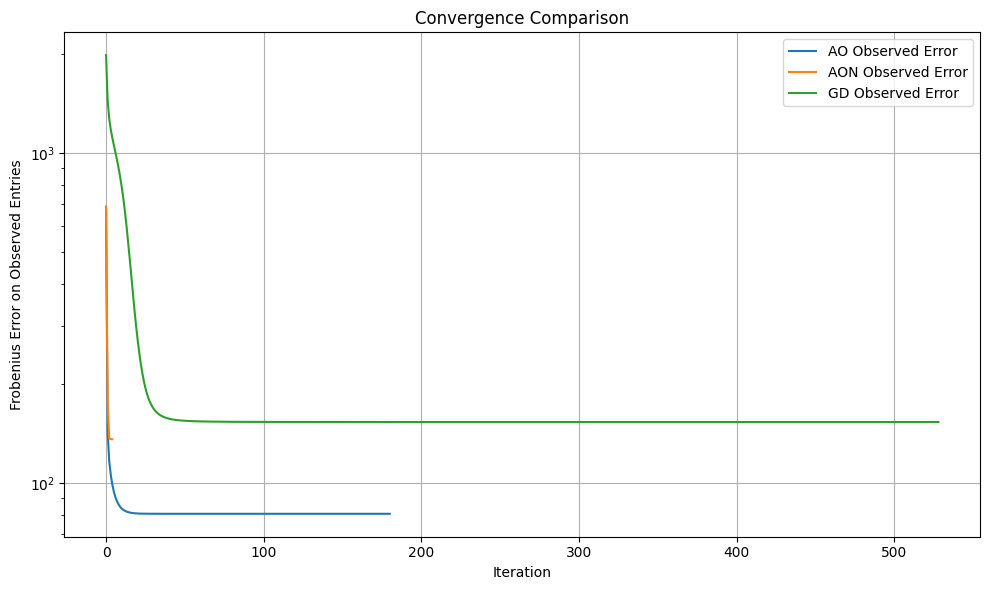

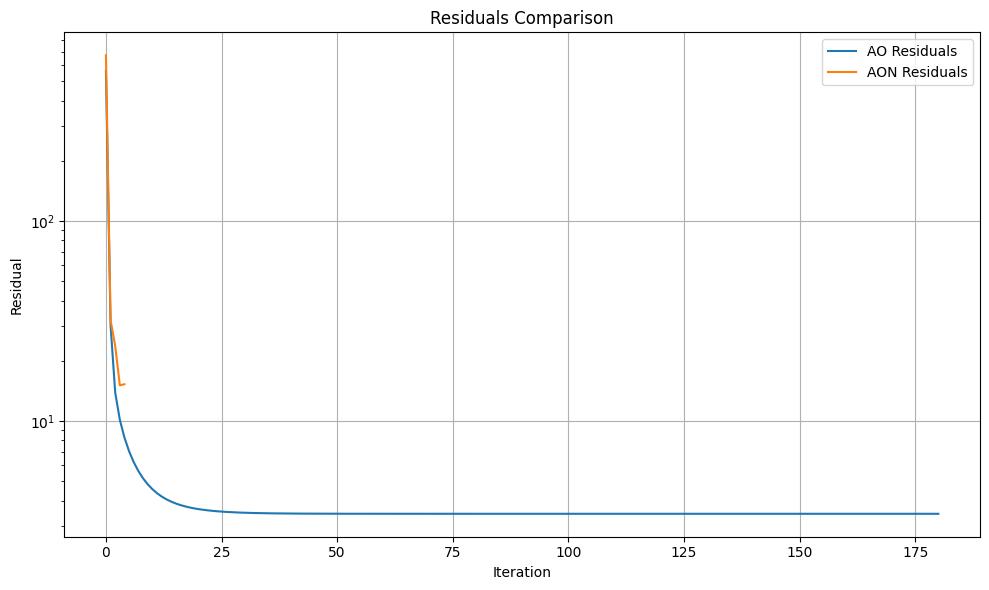

In [53]:
# Benchmark the different initialization strategies
print("=== Gaussian Initialization ===")
u0_g, v0_g = initialize_uv(X_obs, mask, strategy='gaussian', seed=seed)
# Benchmark the different solvers
gauss = compare_solvers(X_obs, X_true, u0_g.copy(), v0_g.copy(), mask, plot=True, gd_params=[9e-3, 7.94e-01])


=== SVD Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=0.000000, Observed Error=0.00000025, Full Error=0.00000475, Iter=64, Time=0.0821s

=== AO with Normalization (AON) ===
AON: Residual=0.000000, Observed Error=0.00000005, Full Error=0.00000057, Iter=63, Time=0.0781s

=== Gradient Descent (GD) ===
GD: Residual=0.000003, Observed Error=0.00106682, Full Error=0.02383007, Iter=1454, Time=0.0406s


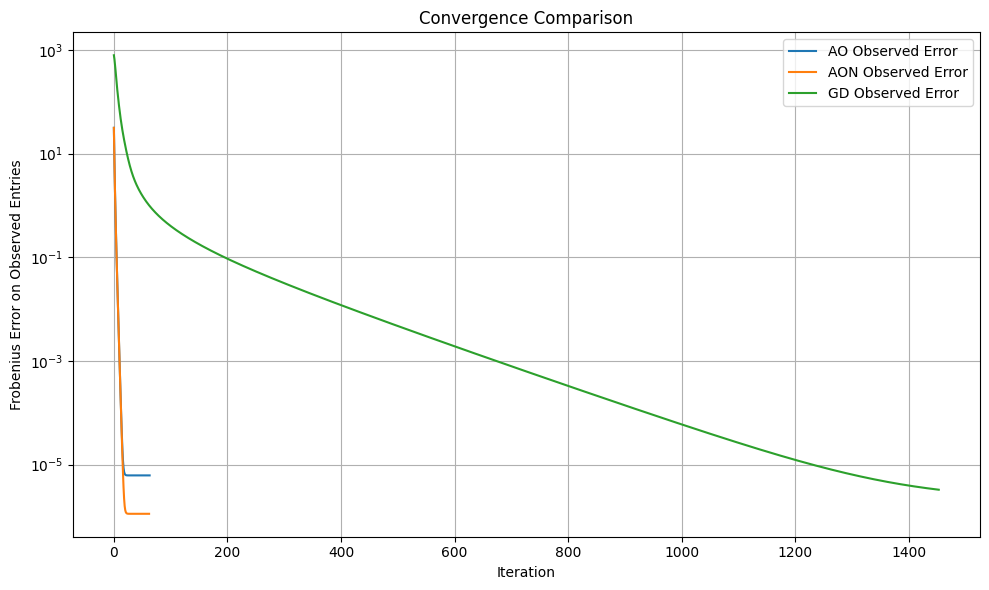

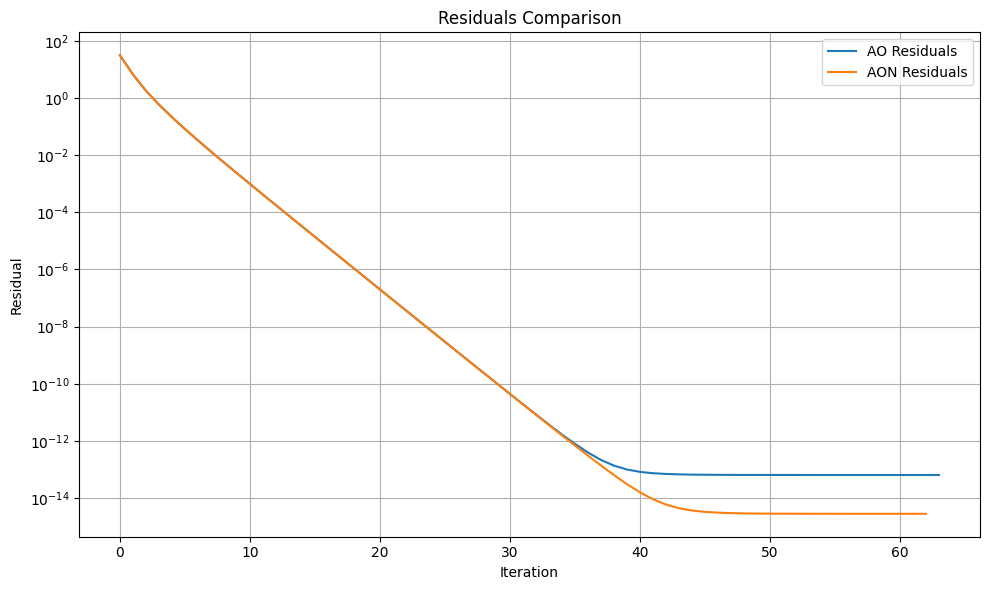

In [54]:
print("\n=== SVD Initialization ===")
u0_s, v0_s = initialize_uv(X_obs, mask, strategy='svd', seed=seed)
svd = compare_solvers(X_obs, X_true, u0_s.copy(), v0_s.copy(), mask, lambda_als=[1e-8, 1e-10],
                      gd_params=[1e-02, 1e-08], plot=True)


=== SVD + Noise Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=0.000001, Observed Error=0.00000074, Full Error=0.00001393, Iter=51, Time=0.0658s

=== AO with Normalization (AON) ===
AON: Residual=0.000000, Observed Error=0.00000005, Full Error=0.00000057, Iter=66, Time=0.0841s

=== Gradient Descent (GD) ===
GD: Residual=0.000003, Observed Error=0.00106875, Full Error=0.02387321, Iter=1450, Time=0.0438s


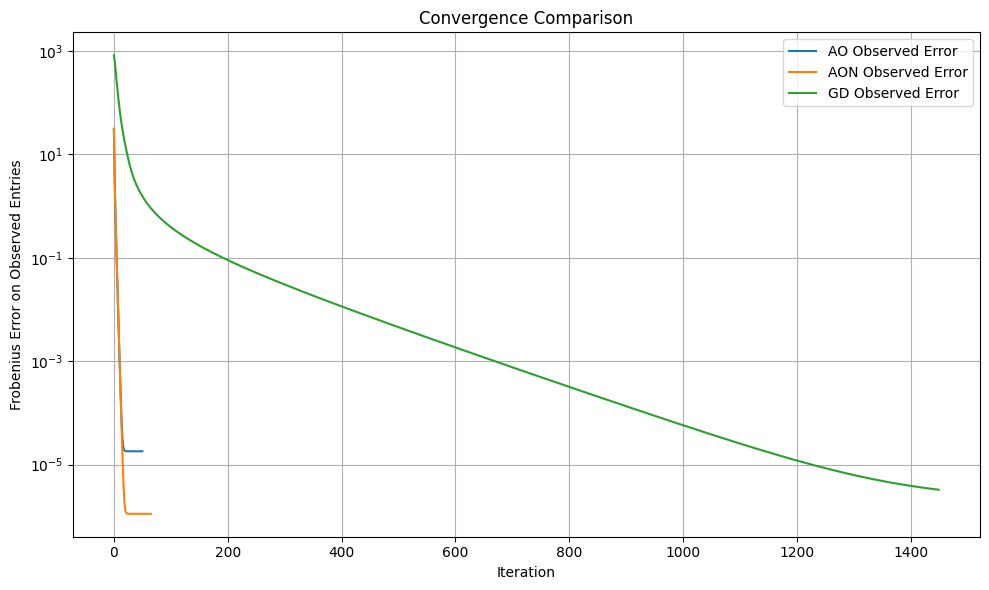

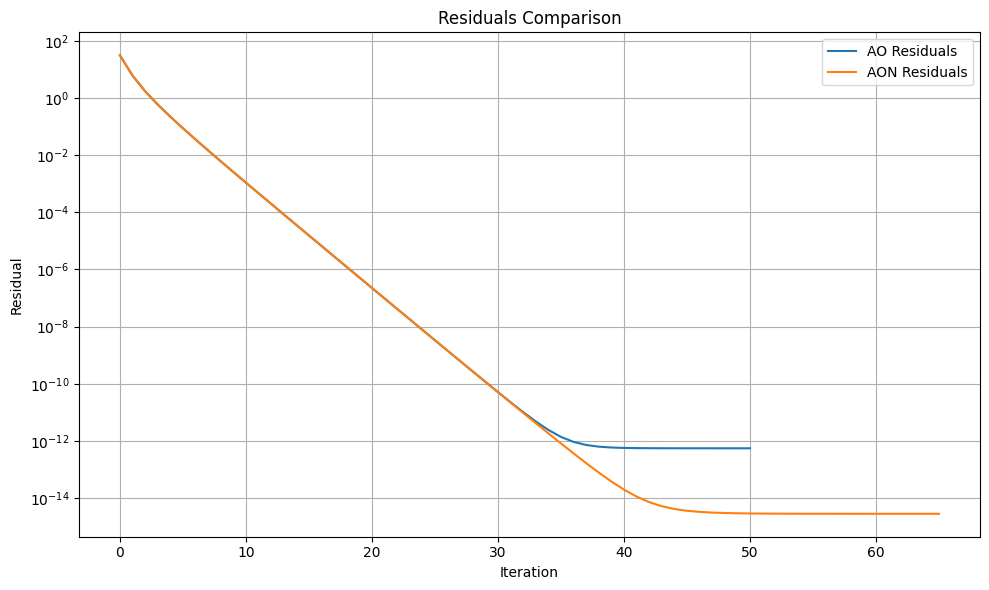

In [55]:
print("\n=== SVD + Noise Initialization ===")
u0_sn, v0_sn = initialize_uv(X_obs, mask, strategy='svd', epsilon=0.1, seed=seed)
svd_n = compare_solvers(X_obs, X_true, u0_sn.copy(), v0_sn.copy(), mask, lambda_als=[3e-8, 1e-10],
                        gd_params=[1e-02, 1e-8], plot=True)


=== Mean Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=15.046777, Observed Error=15.04677659, Full Error=110.55828945, Iter=74, Time=0.0946s

=== AO with Normalization (AON) ===
AON: Residual=13.910546, Observed Error=13.91054578, Full Error=132.82174877, Iter=30, Time=0.0377s

=== Gradient Descent (GD) ===
GD: Residual=233.835040, Observed Error=13.58399015, Full Error=196.75663859, Iter=1500, Time=0.0411s


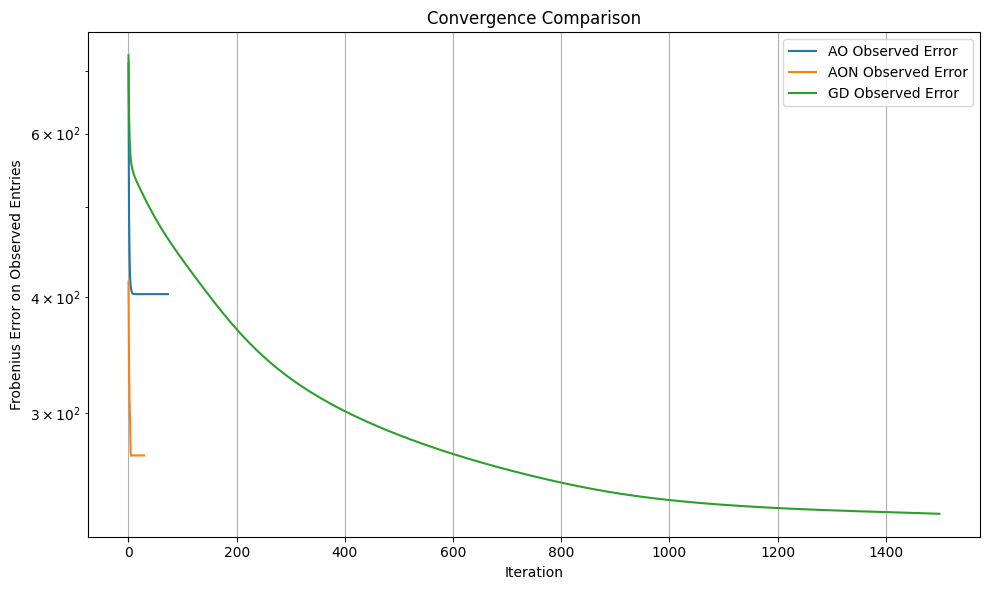

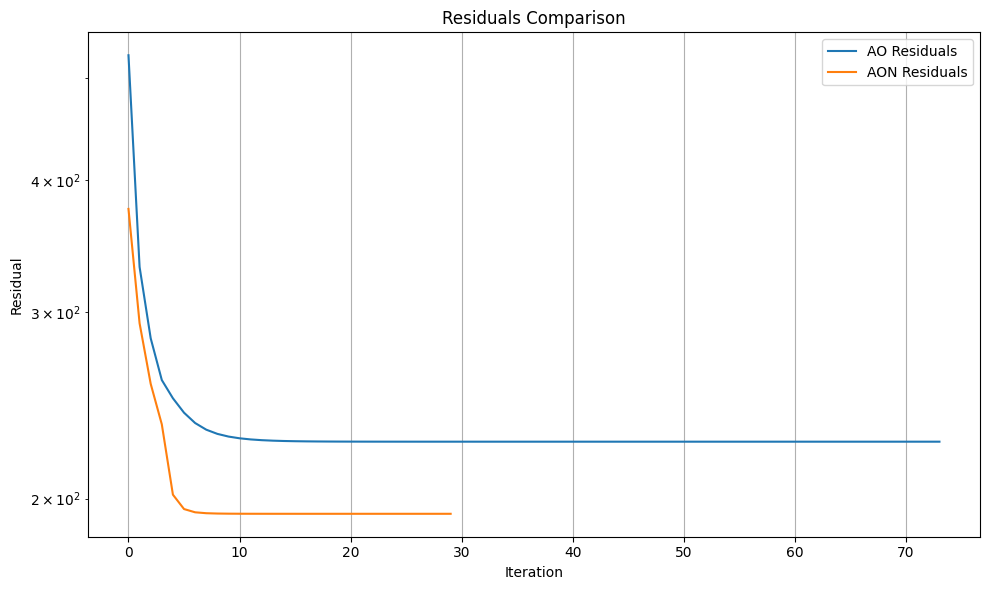

In [56]:
print("\n=== Mean Initialization ===")
u0_m, v0_m = initialize_uv(X_obs, mask, strategy='mean', seed=seed)
mean = compare_solvers(X_obs, X_true, u0_m.copy(), v0_m.copy(), mask, lambda_als=[1e-0, 5.80e-03],
                       gd_params=[2.27e-03, 1.44e-01], plot=True)

In [57]:
# compare the results of the different initializations and solvers in a table
import pandas as pd
from tabulate import tabulate

# Create a DataFrame to store the results
results_ao = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['AO']['observed_error'],
        svd['AO']['observed_error'],
        svd_n['AO']['observed_error'],
        mean['AO']['observed_error']
    ],
    'Full Error': [
        gauss['AO']['full_error'],
        svd['AO']['full_error'],
        svd_n['AO']['full_error'],
        mean['AO']['full_error']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_ao, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization (AO) ===")
print(table_str)

results_aon = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['AON']['observed_error'],
        svd['AON']['observed_error'],
        svd_n['AON']['observed_error'],
        mean['AON']['observed_error']
    ],
    'Full Error': [
        gauss['AON']['full_error'],
        svd['AON']['full_error'],
        svd_n['AON']['full_error'],
        mean['AON']['full_error']
    ]
})

# Convert the DataFrame to a string table
table_str = tabulate(results_aon, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization with Normalization (AON) ===")
print(table_str)

results_gd = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['GD']['observed_error'],
        svd['GD']['observed_error'],
        svd_n['GD']['observed_error'],
        mean['GD']['observed_error']
    ],
    'Full Error': [
        gauss['GD']['full_error'],
        svd['GD']['full_error'],
        svd_n['GD']['full_error'],
        mean['GD']['full_error']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_gd, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Gradient Descent (GD) ===")
print(table_str)


=== Alternating Optimization (AO) ===
+-------------+------------------------+------------------------+
|   Method    |     Observed Error     |       Full Error       |
+-------------+------------------------+------------------------+
|  Gaussian   |   1.8547073725749341   |    17.3010087045636    |
|     SVD     | 2.5329422010471733e-07 | 4.753702246683494e-06  |
| SVD + Noise | 7.421488826498567e-07  | 1.3930563308529395e-05 |
|    Mean     |   15.046776591633092   |   110.55828944591912   |
+-------------+------------------------+------------------------+
=== Alternating Optimization with Normalization (AON) ===
+-------------+------------------------+-----------------------+
|   Method    |     Observed Error     |      Full Error       |
+-------------+------------------------+-----------------------+
|  Gaussian   |   3.909168758529057    |   22.22703096015441   |
|     SVD     | 5.301489439454083e-08  | 5.67248400914983e-07  |
| SVD + Noise | 5.3015287451270346e-08 | 5.67281020